# Excercise 1 Context

1. Sketch a contextsensitive Application

2. Categorize it according to Schilit (explain why)

3. Categorize all relevant context regarding category of context, passive/active and primary/secondary

4. Modify a. to be in another class according to Schilit (Tip: You may modify the previous answer if this does not work)

# Excercise 2 Sensors

WebApp

# Excercise 3 Calculating features

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from influxdb import InfluxDBClient, DataFrameClient

## 3.1 Load Data

In [2]:
# all data in browser database
influxClient = DataFrameClient(host='css20.dmz.teco.edu', port=80, database='browser',username="user", password="pass")
data = influxClient.query("select * FROM devicemotion")["devicemotion"]

In [3]:
# own recorded data
influxClient = DataFrameClient(host='css20.dmz.teco.edu', port=80, database='motion_data',username="user", password="pass")
own_data = influxClient.query("select * FROM devicemotion")["devicemotion"]

In [4]:
data.columns

Index(['acceleration.x', 'acceleration.y', 'acceleration.z',
       'accelerationIncludingGravity.x', 'accelerationIncludingGravity.y',
       'accelerationIncludingGravity.z', 'label', 'mobile',
       'rotationRate.alpha', 'rotationRate.beta', 'rotationRate.gamma',
       'subject', 'useragent'],
      dtype='object')

In [5]:
data.head(2)

,acceleration.x,acceleration.y,acceleration.z,accelerationIncludingGravity.x,accelerationIncludingGravity.y,accelerationIncludingGravity.z,label,mobile,rotationRate.alpha,rotationRate.beta,rotationRate.gamma,subject,useragent
2020-05-18 15:38:31.330200+00:00,0.0514,-0.4303,1.4837,0.038307,5.439626,9.825804,testing,UnknownPhone,-13.115,-43.004999,0.488,10b5c,Mozilla/5.0 (Linux; Android 7.0; FRD-L19) Appl...
2020-05-18 15:38:31.348400+00:00,0.6009,-0.1249,1.0312,0.172383,5.477933,9.174581,testing,UnknownPhone,-2.623,-6.527000,-2.379,10b5c,Mozilla/5.0 (Linux; Android 7.0; FRD-L19) Appl...


In [6]:
data.shape

(346487, 13)

In [7]:
# Select time window
data = data.loc['2020-05-01':'2020-10-07'].dropna()
data.shape

(346231, 13)

## 3.2 Preprocessing (Windowing / Aggregation)

In [8]:
def minmax(data):
    return np.max(data)-np.min(data)

def transform_data(data, labels, subjects):
    ### 3-Step Transformation:
    # 1. Grouping using Labels & Subjects
    # 2. Aggregation using resample with 1s as time resolution
    # 3. Transform data back to pandas dataframe
    
    ### 1. Group data according to labels and subjects
    grouped_data = {}
    for subject in subjects:
        grouped_data[subject] = {}
        subject_data = data[data['subject'] == subject]
        for label in labels:
            grouped_data[subject][label] = subject_data[subject_data["label"] == label]
    
    
    ### 2. Aggregation using resample
    # Prepare aggregation
    numeric_columns = {}
    for col, dtype in zip(data.columns, data.dtypes):
        if dtype == 'float64':
            numeric_columns[col] = ['max', 'mean', 'min',"std", "var",minmax]
    
    # start aggregation
    aggregatedDict = {}
    for subject in subjects:
        aggregatedDict[subject] = {}
        for label in labels:
            # check if part is empty
            if(not grouped_data[subject][label].empty):
                # use resample for frequency conversion 
                aggregatedDict[subject][label] = grouped_data[subject][label].resample('1s').agg(numeric_columns).dropna()
    
    ### 3. Transform data into ungrouped and flat table
    data = pd.DataFrame()
    for subject in subjects:
        for label in labels:
            if label in aggregatedDict[subject]:
                curr_data = aggregatedDict[subject][label]
                # add label
                curr_data["label"] = len(curr_data)*[label]
                # add subject / group
                curr_data["group"] = len(curr_data)*[subject]
                data = data.append(curr_data)
    return data

In [9]:
# Extract labels and subjects
labels = data['label'].unique()[1:] # drop "testing"-label
subjects = data['subject'].unique()
# Apply transformation
data = transform_data(data.copy(), labels, subjects)

In [10]:
len(data)

3826

## 3.3 Robust Outlier-Cleansing

In [11]:
# RMSE 3D_acceleration
minmax_3d_acc = np.sqrt(data["acceleration.x"]["minmax"]**2 + data["acceleration.y"]["minmax"]**2
                        + data["acceleration.z"]["minmax"]**2)

In [12]:
# Calculate Quantiles
Q1 = np.percentile(minmax_3d_acc, 25)  
Q3 = np.percentile(minmax_3d_acc, 75) 
# Calculate IQR
IQR = Q3 - Q1 
# Calculate bounds
low_lim = np.array(Q1 - 3 * IQR)
up_lim = np.array(Q3 + 3 * IQR)
# Get index of outliers
index = np.logical_and(minmax_3d_acc.values >= low_lim, minmax_3d_acc.values <= up_lim)

In [13]:
# Remove outliers
data = data.loc[index]

# 3.4 Visualization of recorded data



In [14]:
# Extract labels and subjects
own_labels = own_data['label'].unique()[1:] # drop "testing"-label
subjects = ["EbiDa"]#own_data['subject'].unique()
# Apply transformation
own_data = transform_data(own_data.copy(), own_labels, subjects)

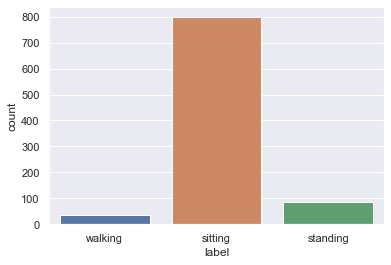

In [15]:
sns.set(style="darkgrid")
ax = sns.countplot(x="label", data=own_data)

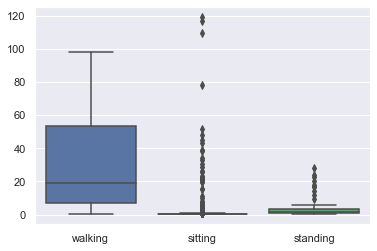

In [16]:
x = own_data["label"].values
y= np.array([(own_data["acceleration." + direction]["minmax"].values) for direction in ["x","y","z"]]).sum(axis=0)
# Box-Plot
sns.set_style("darkgrid")
box_plot = sns.boxplot(x=x,y=y)

# Excercise 4 Creating a predictor

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import RFE

## 4.1 Train-Test Split

In [18]:
# Seed
np.random.seed(2020)

# initialize subjects
subjects = data["group"].unique()

# Draw random Training-Data-Indices
number_subjects = len(subjects)
size = int(0.8*number_subjects)

# Extract Train/Test-Subjects
train_subjects = np.random.choice(subjects, size=size, replace=False)
test_subjects = list(set(subjects)-set(train_subjects))

# Setup train and test data
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for train_subject in train_subjects:
    train_data= train_data.append(data.loc[data["group"] == train_subject])
    
for test_subject in test_subjects:
    test_data= test_data.append(data.loc[data["group"] == test_subject])
    
# finalize train / test data
x_train = train_data.drop(["group", "label"], axis="columns")
x_test = test_data.drop(["group", "label"], axis="columns")
y_train = train_data["label"]
y_test = test_data["label"]

## 4.2 10-Fold-CV

In [19]:
# Seed
np.random.seed(1010)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, early_stopping = True, random_state=42)
mlp_res = cross_validate(mlp, x_train, y_train, n_jobs=-1, cv=10,
                         return_estimator=False, return_train_score=True)

# RF
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_res = cross_validate(rf, x_train, y_train, n_jobs=-1, cv=10,
                         return_estimator=False, return_train_score=True)

print("MLP 10-Fold-CV-Accuracy: ", mlp_res["test_score"].mean())
print("Random Forest 10-Fold-CV-Accuracy: ", rf_res["test_score"].mean())

MLP 10-Fold-CV-Accuracy:  0.6962552370192535
Random Forest 10-Fold-CV-Accuracy:  0.7510732947323826


## 4.3 Leave-One-Subject-Out-CV

In [20]:
# Seed
np.random.seed(1111)

logo = LeaveOneGroupOut()
logo.get_n_splits(groups=train_data["group"].values)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, early_stopping = True, random_state=42)
mlp_res = cross_validate(mlp, x_train, y_train, cv=logo, n_jobs=-1, groups = train_data["group"].values,
                         return_estimator=False, return_train_score=True)

# RF
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_res = cross_validate(rf, x_train, y_train, cv=logo, n_jobs=-1, groups = train_data["group"].values,
                        return_estimator=False, return_train_score=True)

print("MLP LOGO-CV-Accuracy: ", mlp_res["test_score"].mean())
print("Random Forest LOGO-CV-Accuracy: ", rf_res["test_score"].mean())

MLP LOGO-CV-Accuracy:  0.7085044487262049
Random Forest LOGO-CV-Accuracy:  0.7594145289611369


## 4.4 Recursive Feature Elimination

In [21]:
# Seed
np.random.seed(1212)

rfe = RFE(rf, n_features_to_select=10, step=1, verbose=0)
rfe.fit(x_train,y_train)

# evaluate
selected_features = x_train.columns[rfe.support_]
x_train_new = x_train[selected_features]

rf_res_new = cross_validate(rf, x_train_new, y_train, n_jobs=2, cv=logo, groups = train_data["group"].values,
                         return_estimator=False, return_train_score=True)
print("Random Forest - RFE -  LOGO-CV-Accuracy: ", rf_res_new["test_score"].mean())

Random Forest - RFE -  LOGO-CV-Accuracy:  0.7653243356170701


## 4.5 Classifier with Bayes-Optimization

In [22]:
# set budget for Optimization
max_iters = 10

### 4.5.1. MLP

In [23]:
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
# set seeds
np.random.seed(4321)

# define space
mlp_space = {'hidden_layer_sizes' : hp.quniform('hidden_layer_sizes',5,50,1),
             'max_iter' : hp.quniform("max_iter",10,500,1)}

def mlp_opt(params):
    from sklearn.model_selection import LeaveOneGroupOut
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import cross_validate
    
    params["hidden_layer_sizes"] = int(params["hidden_layer_sizes"])
    params["max_iter"] = int(params["max_iter"])
    
    mlp = MLPClassifier(hidden_layer_sizes= params["hidden_layer_sizes"], max_iter= params["max_iter"], random_state=42)
    mlp = cross_validate(mlp, x_train_new, y_train, cv=10, n_jobs=2,
                         return_estimator=False, return_train_score=True)
    
    score = -1* mlp["test_score"].mean()
    return {'loss': score, 'status': STATUS_OK, 'model': None, 'params': params}

### optimization
trials = Trials()
best_mlp = fmin(mlp_opt, mlp_space, algo=tpe.suggest, max_evals= max_iters,trials=trials,
                rstate= np.random.RandomState(1234))
print('best: ')
### Extract params
best_MLP_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
print(best_MLP_params)
# Extract Model
MLP_model = MLPClassifier(hidden_layer_sizes = best_MLP_params["hidden_layer_sizes"], max_iter = best_MLP_params["max_iter"])
MLP_model.fit(x_train_new, y_train)

100%|███████████████████████████████████████████████| 10/10 [04:21<00:00, 23.67s/trial, best loss: -0.7622958150920304]
best: 
{'hidden_layer_sizes': 43, 'max_iter': 232}


C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (232) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(hidden_layer_sizes=43, max_iter=232)

### 4.5.2. Random Forest

In [24]:
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
# set seeds
np.random.seed(4321)

# define space
rf_space = {'n_estimators' : hp.quniform('n_estimators',5,500,1),
             'max_depth' : hp.quniform("max_depth",1,3,1)}

def rf_opt(params):
    from sklearn.model_selection import LeaveOneGroupOut
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import cross_validate
    
    logo = LeaveOneGroupOut()
    logo.get_n_splits(groups=train_data["group"].values)
    
    params["n_estimators"] = int(params["n_estimators"])
    params["max_depth"] = int(params["max_depth"])
    
    rf = RandomForestClassifier(n_estimators=params["n_estimators"], max_depth=params["max_depth"], random_state=42)
    rf = cross_validate(rf, x_train_new, y_train, cv=logo, n_jobs=2, groups = train_data["group"].values,
                         return_estimator=False, return_train_score=True)
    
    score = -1* rf["test_score"].mean()
    return {'loss': score, 'status': STATUS_OK, 'model': None, 'params': params}

### optimization
trials = Trials()
best_rf = fmin(rf_opt, rf_space, algo=tpe.suggest, max_evals= max_iters,trials=trials,
                rstate= np.random.RandomState(1234))
print('best: ')
### Extract params
best_RF_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
print(best_RF_params)
# Extract Model
RF_model = RandomForestClassifier(n_estimators = best_RF_params["n_estimators"], max_depth = best_RF_params["max_depth"])
RF_model.fit(x_train_new, y_train)

100%|███████████████████████████████████████████████| 10/10 [03:47<00:00, 20.24s/trial, best loss: -0.7656476163907526]
best: 
{'max_depth': 3, 'n_estimators': 156}


RandomForestClassifier(max_depth=3, n_estimators=156)

## 4.6 Evaluate on Test-Data

In [25]:
RF_model.score(x_test[selected_features],y_test)

0.6596931659693166

## 4.7 Refit Random Forest using all data

In [26]:
X = x_train.append(x_test)
y = np.concatenate([y_train, y_test])
RF_model.fit(X[selected_features], y )

RandomForestClassifier(max_depth=3, n_estimators=156)

In [27]:
# Print classes to check if js output is valid
RF_model.classes_

array(['shaking', 'sitting', 'standing', 'walking', 'waving'],
      dtype=object)

## 4.8 Export Model

In [ ]:
from sklearn_porter import Porter

# export model using Porter
porter = Porter(RF_model, language='js')
output = porter.export(embed_data=True)
# print(output)


# write String to JS-TextFile
text_file = open("random-forest.js", "w")
text_file.write(output)
text_file.close()

# Appendix: Comparison of different classification methods: Why we choose RF and MLP

In [ ]:
from sklearn.datasets import fetch_covtype
from sklearn.metrics import precision_recall_fscore_support,matthews_corrcoef
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [ ]:
### define and name set of classifiers to evaluate predictions of different methods ###
classifiers = [KNeighborsClassifier(3),
               KNeighborsClassifier(5),
               KNeighborsClassifier(10),
               DecisionTreeClassifier(max_depth=5),
               DecisionTreeClassifier(max_depth=10),
               DecisionTreeClassifier(max_depth=20),
               RandomForestClassifier(n_estimators=1000, max_depth=3),
               RandomForestClassifier(n_estimators=1000, max_depth=5),
               LogisticRegression(max_iter=100000),
               GaussianNB(),
               MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                             max_iter=10000, activation='relu'),
               MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                             max_iter=10000, activation='tanh')]

clf_names = ["Nearest Neighbors (k=3)",
             "Nearest Neighbors (k=5)",
             "Nearest Neighbors (k=10)",
             "Decision Tree (Max Depth=5)",
             "Decision Tree (Max Depth=10)",
             "Decision Tree (Max Depth=20)",
             "Random Forest (Max Depth=3)",
             "Random Forest (Max Depth=5)",
             "Logistic Regression",
             "Gaussian Naive Bayes",
             "MLP (RelU)",
             "MLP (tanh)"]

In [ ]:
scores_micro = dict()
scores_macro = dict()
scores_mcc = dict()

for name, clf in zip(clf_names, classifiers):
    print("fitting classifier", name)
    clf.fit(x_train, y_train)
    print("predicting labels for classifier", name)
    y_pred = clf.predict(x_test)
    scores_micro[name] = precision_recall_fscore_support(
        y_test, y_pred, average="micro")
    scores_macro[name] = precision_recall_fscore_support(
        y_test, y_pred, average="macro")
    scores_mcc[name] = matthews_corrcoef(y_test, y_pred)

# micro aggregates the contributions of all classes to compute the average metric --> good for class imbalance
scores_micro_df = pd.DataFrame(scores_micro, index=[
                               'precision (micro)', 'recall (micro)', 'fscore (micro)', 'support'])
scores_micro_df = scores_micro_df[0:3]
# macro computes the metric independently for each class and then take the average
scores_macro_df = pd.DataFrame(scores_macro, index=[
                               'precision (macro)', 'recall (macro)', 'fscore (macro)', 'support'])
scores_macro_df = scores_macro_df[0:3]
scores_df = scores_macro_df.append(scores_micro_df).append(
    pd.Series(scores_mcc, name='MCC'))

In [ ]:
scores_df

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(12,7))
plot_confusion_matrix(classifiers[7], x_test, y_test, cmap=plt.cm.Blues, ax=axes[0])
plot_confusion_matrix(classifiers[11], x_test, y_test, cmap=plt.cm.Blues, ax=axes[1])
axes[0].set_title(clf_names[7])
axes[1].set_title(clf_names[11])
plt.show()